In [ ]:
# import sys
# sys.executable
# import os
# os.getcwd()
# sys.path.append('devel/lib/python3/dist-packages/theconstruct_msgs/msg/')
# sys.path.append('/home/nils/Documents/Studium/Bachelorarbeit/praktischer_Teil/moveo_DRL/src')
# sys.path.append('/home/nils/Documents/Studium/Bachelorarbeit/praktischer_Teil/moveo_DRL/src/moveo_training/scripts')
# sys.path.append('/home/nils/Documents/Studium/Bachelorarbeit/praktischer_Teil/moveo_DRL/devel/lib/python3/dist-packages/openai_ros/msg')

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.networks import actor_distribution_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

from src.moveo_training.src.moveo_training import moveo_inverse_kinematic_discrete_MultiActions
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

2021-08-31 18:28:40.928970: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nils/Documents/Studium/Bachelorarbeit/praktischer_Teil/moveo_DRL/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu
2021-08-31 18:28:40.929008: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Failed to import pyassimp, see https://github.com/ros-planning/moveit/issues/86 for more info


In [2]:
num_iterations = 10000 # @param {type:"integer"}
collect_episodes_per_iteration = 2 # @param {type:"integer"}
replay_buffer_capacity = 2000 # @param {type:"integer"}

fc_layer_params = (100,)

learning_rate = 1e-3 # @param {type:"number"}
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 200 # @param {type:"integer"}

In [3]:
import rospy
rospy.init_node("train_moveo_her")
env_name = 'MoveoIK_discrete_MultiActions-v0' # @param {type:"string"}
env = suite_gym.load(env_name)

[ERROR] [1630427330.014531, 691096.842000]: NOT Initialising Simulation Physics Parameters
[WARN] [1630427330.030262, 691098.042000]: Start Init ControllersConnection
[WARN] [1630427330.031687, 691098.042000]: END Init ControllersConnection
/home/nils/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
env.reset()
# PIL.Image.fromarray(env.render())

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([0.5669996, 0.3      , 0.3      , 0.3      ], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

In [5]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[ 0. -1. -1. -1.], maximum=[2. 1. 1. 1.])
Action Spec:
BoundedArraySpec(shape=(5,), dtype=dtype('int32'), name='action', minimum=0, maximum=269)


In [6]:
time_step = env.reset()
print('Time step:')
print(time_step)

# action = np.array(1, dtype=np.int32)

# next_time_step = env.step(action)
# print('Next time step:')
# print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([0.5669996, 0.3      , 0.3      , 0.3      ], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})


In [7]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

[ERROR] [1630427340.185363, 692094.142000]: NOT Initialising Simulation Physics Parameters
[WARN] [1630427340.193072, 692095.042000]: Start Init ControllersConnection
[WARN] [1630427340.196178, 692095.042000]: END Init ControllersConnection
[ERROR] [1630427340.265709, 692101.042000]: NOT Initialising Simulation Physics Parameters
[WARN] [1630427340.276244, 692102.242000]: Start Init ControllersConnection
[WARN] [1630427340.277596, 692102.242000]: END Init ControllersConnection


In [8]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [9]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

2021-08-31 18:29:04.787489: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-31 18:29:04.830868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 18:29:04.836255: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 970 computeCapability: 5.2
coreClock: 1.2155GHz coreCount: 13 deviceMemorySize: 3.94GiB deviceMemoryBandwidth: 208.91GiB/s
2021-08-31 18:29:04.837377: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nils/Documents/Studium/Bachelorarbeit/praktischer_Teil/moveo_DRL/devel/lib:/opt/ros/noetic/lib:/opt/ros

In [10]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

In [11]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# Please also see the metrics module for standard implementations of different
# metrics.

In [12]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [13]:
def collect_episode(environment, policy, num_episodes):

  episode_counter = 0
  environment.reset()

  while episode_counter < num_episodes:
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

    if traj.is_boundary():
      episode_counter += 1


# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

In [14]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(
      train_env, tf_agent.collect_policy, collect_episodes_per_iteration)

  # Use data from the buffer and update the agent's network.
  experience = replay_buffer.gather_all()
  train_loss = tf_agent.train(experience)
  replay_buffer.clear()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


2021-08-31 18:29:32.429199: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-31 18:29:32.456184: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3192625000 Hz
[ WARN] [1630427374.392211991, 695450.942000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427374.885687378, 695499.642000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427376.266402043, 695633.842000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427376.633662924, 695669.342000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427378.413492702, 695844.942000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427381.588048887, 696153.842000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427382.475158844, 696238.942000000]: Fail: ABORTE

Ziel wurde erreicht Reward=  1000


[ WARN] [1630427395.329635495, 697488.342000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427395.718677200, 697526.442000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427396.001772565, 697554.242000000]: Fail: ABORTED: No motion plan found. No execution attempted.


step = 25: loss = -16.187305450439453


[ WARN] [1630427397.414678055, 697692.342000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427398.515189801, 697797.842000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427402.700591425, 698205.442000000]: Fail: ABORTED: No motion plan found. No execution attempted.


Ziel wurde erreicht Reward=  1000


[ WARN] [1630427404.860382149, 698415.242000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427405.201071027, 698448.542000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ERROR] [1630427405.201885100, 698448.642000000]: Got a callback on a goalHandle that we're not tracking.                 This is an internal SimpleActionClient/ActionClient bug.                 This could also be a GoalID collision
[ WARN] [1630427406.091004123, 698536.442000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427406.403425618, 698567.442000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427407.339948986, 698660.242000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427409.327138545, 698853.842000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427411.694402296, 699085.442000000]: Fail: ABORTED: No motion plan found. No execution a

step = 50: loss = -14.832271575927734


[ WARN] [1630427420.395773282, 699937.242000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427425.316745933, 700418.342000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427429.737554706, 700847.442000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427433.150727671, 701182.342000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427434.045612082, 701269.742000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427434.956788526, 701356.242000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427436.586184367, 701517.042000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ INFO] [1630427328.585143750]: Loading robot model 'moveo_description'...
[ INFO] [1630427328.585978145]: No root/virtual joint specified in SRDF. Assuming fixed joint
[ INFO] [1630427330.004336672, 691095.842000000]: Ready to take commands for planning group arm.
[ INFO] [1630427340.157374934, 692092.242000000]: Ready to take commands for planning group arm.
[ INFO] [1630427340.253117134, 692099.642000000]: Ready to take commands for planning group arm.
[ INFO] [1630427374.529569530, 695464.142000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427374.959016745, 695506.442000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427376.310365357, 695638.342000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427376.716372832, 695677.742000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427378.487315310, 695851.842000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [163042

[ WARN] [1630427437.542345416, 701610.842000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427437.785322039, 701634.542000000]: Fail: ABORTED: No motion plan found. No execution attempted.


Ziel wurde erreicht Reward=  1000


[ WARN] [1630427440.366004315, 701886.342000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427442.920798951, 702140.342000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427444.740756857, 702318.542000000]: Fail: ABORTED: No motion plan found. No execution attempted.


step = 75: loss = -15.464795112609863


[ WARN] [1630427445.128511253, 702357.342000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427448.872922564, 702724.742000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427452.942924817, 703127.842000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427454.512198807, 703283.242000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427457.388762262, 703567.242000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427458.823854952, 703708.242000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427460.667215775, 703889.742000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427461.946897856, 704015.942000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427464.776952400, 704296.142000000]: Fail: ABORTED: No motion plan found. No execution attempted.


step = 100: loss = -16.90677833557129


[ WARN] [1630427469.608432528, 704767.842000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427480.896619633, 705857.642000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427481.642446616, 705929.742000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427486.094959263, 706368.342000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427487.337182764, 706490.042000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427489.232158821, 706678.242000000]: Fail: ABORTED: No motion plan found. No execution attempted.


step = 125: loss = -11.293200492858887


[ WARN] [1630427494.887212102, 707237.942000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427498.462956165, 707590.542000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427499.277402417, 707671.742000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427501.527662448, 707893.242000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427502.345915312, 707974.242000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427504.658332789, 708202.642000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427506.545175298, 708389.842000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427508.422275052, 708575.642000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427509.357808005, 708668.142000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[

step = 150: loss = -17.787616729736328


[ WARN] [1630427518.200138795, 709528.642000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427519.013819925, 709607.942000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427520.933267500, 709797.842000000]: Fail: ABORTED: No motion plan found. No execution attempted.


tion attempted.
[ INFO] [1630427437.616916380, 701618.542000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427437.818018520, 701637.942000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427440.489568814, 701899.042000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427443.085025695, 702155.742000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427444.794689775, 702324.142000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427445.171119562, 702361.442000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427448.918351969, 702728.742000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427452.979720635, 703131.542000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427454.551732763, 703287.342000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427457.452841136, 703573.7

[ WARN] [1630427524.019501081, 710104.242000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427531.566028484, 710852.142000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427532.218516019, 710916.242000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427532.976108716, 710991.342000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427533.716139103, 711064.142000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427534.920311189, 711184.442000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427536.658237385, 711356.442000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427540.459547378, 711731.442000000]: Fail: ABORTED: No motion plan found. No execution attempted.


step = 175: loss = -4.100080490112305


[ WARN] [1630427540.832280849, 711767.742000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427541.156371603, 711799.042000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427542.077566529, 711890.342000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427542.933903916, 711974.542000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427545.327203469, 712210.042000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427548.230912708, 712495.842000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427550.386226448, 712708.042000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427550.723267215, 712740.942000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427552.437173274, 712911.142000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[

step = 200: loss = -16.0831298828125
step = 200: Average Return = -3.7958133220672607


[ WARN] [1630427568.337903249, 714476.742000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427573.711577844, 715001.942000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427575.114502989, 715139.742000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427577.215490850, 715344.842000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427578.309836918, 715452.042000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427578.896913102, 715507.042000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427579.287272182, 715545.342000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427579.666260722, 715583.042000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427579.945307102, 715610.342000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[

FO] [1630427521.036078044, 709807.842000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427524.062346096, 710108.242000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427531.602778212, 710855.742000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427532.685377243, 710962.542000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427533.032934204, 710996.842000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427533.761451089, 711068.242000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427534.974329971, 711189.442000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427536.712073243, 711361.442000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427540.534117514, 711738.542000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1630427540.876772886, 711771.842000000]: ABORTED: 

[ WARN] [1630427589.682422495, 716562.442000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427590.385272283, 716631.442000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427591.240462539, 716716.742000000]: Fail: ABORTED: No motion plan found. No execution attempted.


step = 225: loss = -14.279934883117676


[ERROR] [1630427592.955646629, 716884.942000000]: Got a callback on a goalHandle that we're not tracking.                 This is an internal SimpleActionClient/ActionClient bug.                 This could also be a GoalID collision
[ WARN] [1630427594.544863103, 717041.842000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ERROR] [1630427594.806738915, 717066.742000000]: Got a callback on a goalHandle that we're not tracking.                 This is an internal SimpleActionClient/ActionClient bug.                 This could also be a GoalID collision
[ WARN] [1630427594.888991947, 717074.842000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427595.323724606, 717116.842000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427598.941462500, 717475.842000000]: Fail: ABORTED: No motion plan found. No execution attempted.
[ WARN] [1630427599.654164278, 717546.342000000]: Fail: ABORTED: No motion plan found. No 

KeyboardInterrupt: 

(-1049.899664390087, 250.0)

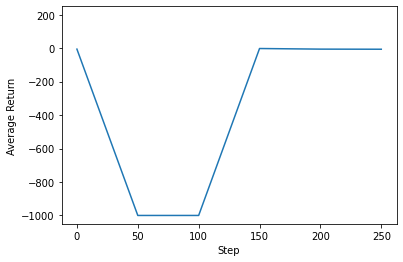

In [ ]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=250)